## Implementation and Notes for Tutorial Article by Daniel Nouri
- [Using convolutional neural nets to detect facial keypoints tutorial by Daniel Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)
- [Kaggle forum thread](https://www.kaggle.com/c/facial-keypoints-detection/details/deep-learning-tutorial)
- more about lasagne and nolearn
    - [Tutorial: Training convolutional neural networks with nolearn](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb)
    - [Kaggle: Otto Group Product Classification Challenge using nolearn/lasagne](https://github.com/ottogroup/kaggle/blob/master/Otto_Group_Competition.ipynb)
    - [mnist_conv_autoencode.ipynb](https://github.com/mikesj-public/convolutional_autoencoder/blob/master/mnist_conv_autoencode.ipynb)

*** Use ~~keras~~ Lasagne and nolearn wrapper. Note that lasage needs latest development version of theano***
```sh
[sudo] git pip install git+https://github.com/Theano/Theano.git@15c90dd3#egg=Theano==0.8.git
```

In [1]:
!cat /home/dola/.theanorc

[global]
floatX = float32
device = gpu0
#device = cpu

[nvcc]
fastmath = True

In [2]:
!head -n 1 ../data/kaggle-facial-keypoints/training.csv

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle

In [4]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

In [5]:
from lasagne import layers, updates
 ## nolearn wrapper for lasagne, need to install from git to support new lasagne
from nolearn.lasagne import NeuralNet
import theano

Using gpu device 0: Quadro K2000 (CNMeM is disabled)


In [6]:
from keras.models import Sequential
from keras.layers.core import Dense


In [7]:
## load data
def load_data(data_path):
    data = pd.read_csv(data_path)
    data["Image"] = data.Image.apply(lambda s: np.fromstring(s, sep = " "))
    return data

train_data = load_data("../data/kaggle-facial-keypoints/training.csv")
test_data = load_data("../data/kaggle-facial-keypoints/test.csv")
print train_data.shape, test_data.shape

(7049, 31) (1783, 2)


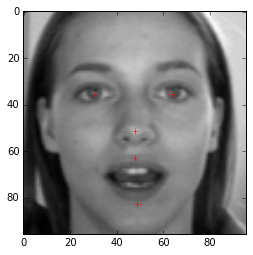

In [8]:
## show an example
i = 30
plt.imshow(train_data["Image"].iloc[i].reshape(96, 96), cmap = plt.cm.gray)
plt.autoscale(False)
for p in [("left_eye_center_x","left_eye_center_y"), ("right_eye_center_x","right_eye_center_y")
         , ("nose_tip_x","nose_tip_y"), ("mouth_center_top_lip_x","mouth_center_top_lip_y"),
         ("mouth_center_bottom_lip_x","mouth_center_bottom_lip_y")]:
    xx, yy = train_data.ix[i, list(p)]
    plt.plot(xx, yy, "r+")

In [9]:
## prepare train and test data
## take images with all 30 targest, 
## normalize pixels to [0, 1], output (xs, ys) to [-1, 1]
X = np.vstack(train_data.dropna()["Image"]).astype(np.float32)
X = X / 255.
y = train_data.dropna()[[c for c in train_data.columns if c != "Image"]].get_values().astype(np.float32)
y = (y - 48.) / 48. # originally 96 x 96
## shuttle the data
X, y = shuffle(X, y, random_state = 0)
XX = X.reshape((-1, 1, 96, 96))
## split train and validation data

print X.shape, y.shape, XX.shape
print X.dtype, y.dtype
print X.min(), X.max(), y.min(), y.max()

(2140, 9216) (2140, 30) (2140, 1, 96, 96)
float32 float32
0.0 1.0 -0.920287 0.99602


### helper functions

In [10]:
## how good or bad it applies to test data
def plot_face(img, ax):
    ax.imshow(img.reshape(96, 96), cmap = plt.cm.gray)
def plot_features(pts, ax):
    ax.autoscale(False)
    for pt in pts:
        x, y = pt
        ax.plot(x, y, "r+")

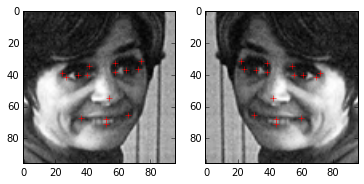

In [11]:
## example of mirror the image
def mirror_vertical(v):
    pts = np.array(zip(v[::2], v[1::2]))
    ## x becomes 0 - x 
    pts[:, 0] = -1. * pts[:, 0]
    ## change left to right
    swap = [(0, 1), (2, 4), (3, 5), (6, 8), (7, 9), (11, 12)]
    for left, right in swap:
        #a = pts[left, :].copy()
        #pts[left, :] = pts[right, :]
        #pts[right,:] = a
        pts[[left, right], :] = pts[[right, left], :]
    return pts.ravel()

i = 0
img = XX[i].reshape((96, 96))
mimg = img[:, ::-1]
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = mirror_vertical(y[i,:])
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

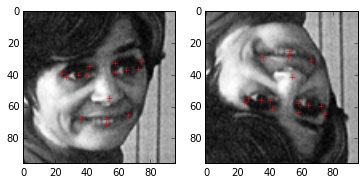

In [12]:
## example of mirror the image
def mirror_horizontal(v):
    pts = np.array(zip(v[::2], v[1::2]))
    ## x becomes 0 - x 
    pts[:, 1] = -1. * pts[:, 1]
    ## change left to right
    return pts.ravel()

i = 0
img = XX[i].reshape((96, 96))
mimg = img[::-1, :]
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = mirror_horizontal(y[i,:])
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

### Trying MLP

mlp takes flatten image vectors

In [9]:
## benchmark MLP with 1 hidden layer
## using nolearn wrapper - sklearn style interface - it follows an interface to sklearn.pipeline
net1 = NeuralNet(
    ## three layers
    layers = [("input", layers.InputLayer)
             , ("hidden", layers.DenseLayer)
             , ("output", layers.DenseLayer)]
    ## layer parameters - see lasagne.layers.XXX for parameter details
    , input_shape = (None, 9216) # batch size not fixed, input dim is 9216
    , hidden_num_units = 100
    , output_nonlinearity = None
    , output_num_units = 30
    
    ## optimization - update parameters,
    , update = updates.nesterov_momentum ## applicable to a wide range of problems
    , update_learning_rate = 0.01 # 0.01 and 0.9, kinda like defacto
    , update_momentum = 0.9
    
    ## problem and objective seeting
    , regression = True
    , max_epochs = 400
    , verbose = 1
)
%time net1.fit(X, y)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.13122       0.04306      3.04714  0.12s
      2       0.04364       0.02832      1.54096  0.12s
      3       0.02091       0.01716      1.21869  0.11s
      4       0.01487       0.01431      1.03857  0.10s
      5       0.01296       0.01310      0.98889  0.12s
      6       0.01210       0.01239      0.97633  0.12s
      7       0.01150       0.01186      0.96925  0.10s
      8       0.01102       0.01144      0.96330  0.11s
      9       0.01063       0.01108      0.95965  0.11s
     10       0.01030       0.01076      0.95718  0.09s
     11       0.01000       0.01049      0.95361  0.09s
     12       0.00974       0.01025      0.95040  0.10s
     13       0.00951       0.01003      0.9

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a190>,
     custom_score=None, hidden_num_units=100, input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7fa33a106d70>,
     objective_loss_function=<function squared_error at 0x7fa33a186050>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7fa32e0ae710>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7fa32e0ae908>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit objec

(0.001, 0.01)

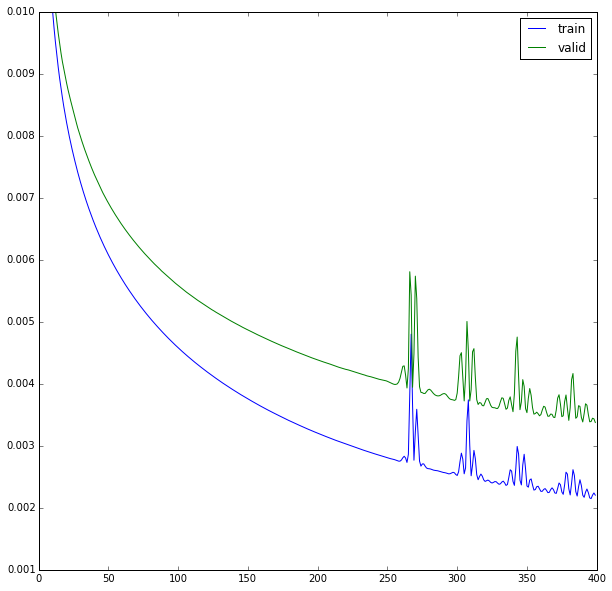

In [10]:
## the most important thing is to get as close as possible to data and model
## e.g., see the train and validation performance
## doesnt look like an overfit because valid is still decreasing/flattening out
## however there is a increasing gap between train and valid error
net1_train_errors = np.array([t["train_loss"] for t in net1.train_history_])
net1_valid_errors = np.array([t["valid_loss"] for t in net1.train_history_])
epochs = np.arange(0, net1_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net1_train_errors, "b-", label = "train")
plt.plot(epochs, net1_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

NameError: name 'net1' is not defined

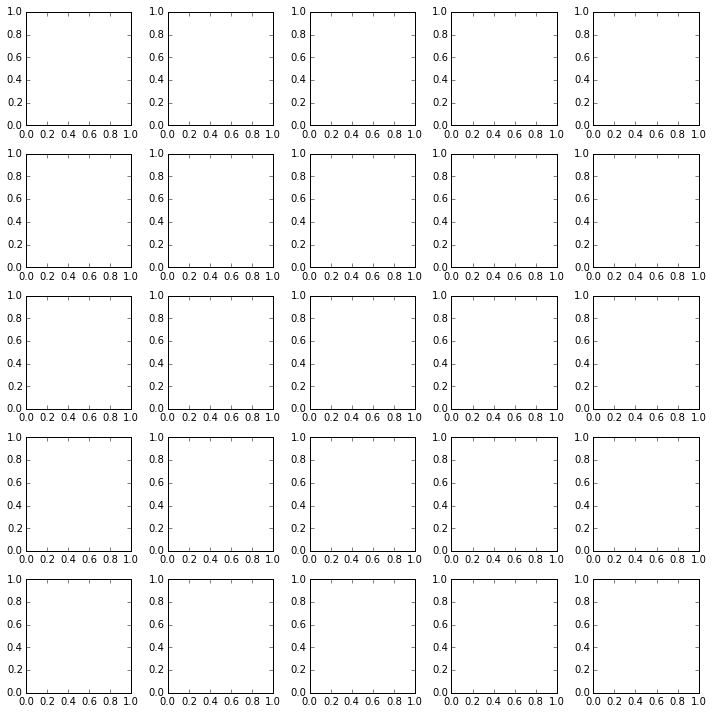

In [9]:

        
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net1.predict([img/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

### Trying CNN

cnn takes (nchannel, width, height) images

In [12]:
## layer pattern is (conv, pool+)+
## number of filters are doubled each layer why????

net2 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (2, 2) # 32 x 95 x 95
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = 0.01 ## deafults are good start
    , update_momentum = 0.9
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 400
    , verbose = 1
)

XX = X.reshape((-1, 1, 96, 96))
%time net2.fit(XX, y)

# Neural Network with 8051342 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x95x95
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.09496       0.02015      4.71339  5.02s
      2       0.01398       0.00914      1.53004  5.25s
      3       0.00846       0.00791      1.06909  5.07s
      4       0.00732       0.00732      1.00038  4.93s
      5       0.00696       0.00699      0.99629  4.99s
      6       0.00669       0.00673      0.99475  4.98s
      7       0.00647       0.00650      0.99588  4.93s
      8       0.00628       0.00630      0.99676  4.97s
      9       0.00612       0.00613      0.99748  5.10s
     10       0.00597       0.00598      0.99807  5.0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a190>,
     conv1_filter_size=(2, 2), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7fa33a106d70>,
     objective

In [23]:
cPickle.dump(net2, open("../data/kaggle-facial-keypoints/models/lasagne/net2.pkl", "w"), -1)

(0.001, 0.01)

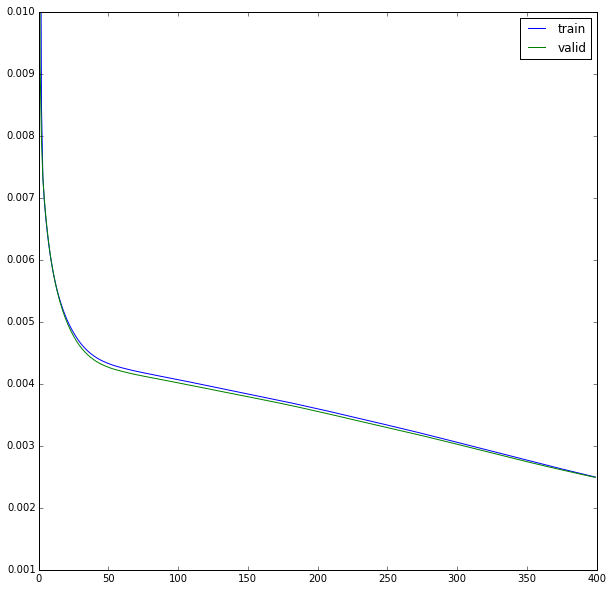

In [20]:
## obviously it is not fully trained with 400 epochs, because both train and valid 
## are tightly decreasing.
## but I stop here because it takes long time to finish the full training in the demostration
net2_train_errors = np.array([t["train_loss"] for t in net2.train_history_])
net2_valid_errors = np.array([t["valid_loss"] for t in net2.train_history_])
epochs = np.arange(0, net2_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net2_train_errors, "b-", label = "train")
plt.plot(epochs, net2_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

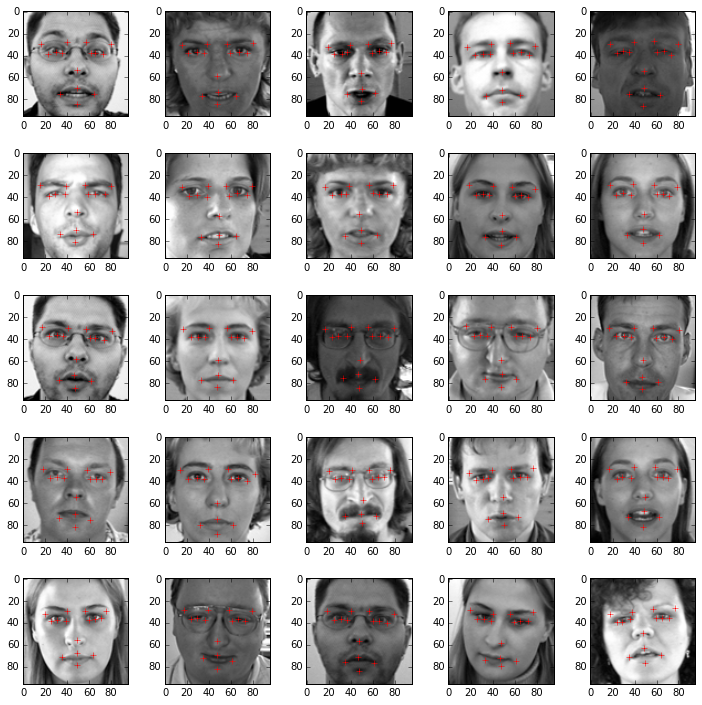

In [21]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net2.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

## Notes

The following codes are organized in a little bit messy way, I will try to clean it some time in the future. Genreally we are not happy with the result introduced on the original blog, as it seems that the model is still trying to predict the `average` positions of features instead of utilizing the image features. For example (1) a random face image from web won't be predicted very well by the model (2) random generated 96x96 matrix will generate almost same positions - the averaged.

So in the following we propose to increase the variaty of data by argumenting with
- fliping the image as in a mirror, either horizontally or vertically
- jittering the images by a small random offset in two axes
- generating octaves - zooming in and the zooming out

We also combined them with the techniques suggested in the blog, including "agumenting data by using BatchIterator" and "linearly decreasing learning rate and increasing momentum by epoch_finish callback".

The experiments showed that 
- flipping works fine but improves generalization just a little bit
- we havn't try octaves 
- jittering is interesting:
    - naive jittering will accumulate the effect, because the batch Xb, yb used by BatchIterator are implemented by share variable
    - the accumulated effect would make the training of the model `diverge`, as some of the faces will be eventually moved out the image
    - to overcome this, we have tried two choices
        - mark the features anyway, even when the face is out of focus, and it didn't work well
        - don't accumulate, just jitter a little every time - the easist implementation is to copy the batch Xb, yb every time before process them. It works, and the training time doesn't increase significantly, and the results look better.

### Augment the data on the fly
- idea: flip images along vertical axis (mirror) to get double size of training
- do it on the fly via BatchIterator to avoid large memory usage
- need to change both image and target when mirroring the image (x -> 1-x, left -> right)

In [13]:
## use BatchIterator to do on-the-fly image augumentation
from nolearn.lasagne.base import BatchIterator

class FlipBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        """
        Xb, yb are batch of inputs and outputs
        Flip 1/3 of images leftside right, Flip 1/3 of images upside down
        """
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)
        batch_size = Xb.shape[0]
        ## vertical flip
        selected = np.random.choice(batch_size, batch_size/2, replace = False)
        N = selected.shape[0]
        Xb[selected[:N/2], ...] = Xb[selected[:N/2], :, :, ::-1]
        yb[selected[:N/2], ...] = np.array(map(mirror_vertical, yb[selected[:N/2], ...]))
        ## horizontal flip
        Xb[selected[N/2:], ...] = Xb[selected[N/2:], :, ::-1, :]
        yb[selected[N/2:], ...] = np.array(map(mirror_horizontal, yb[selected[N/2:], ...]))
        return Xb, yb

In [96]:
## network 3 is exactly the same as network 2, except the new data augument BatchIterator


net3 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (2, 2) # 32 x 95 x 95
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = 0.01 ## deafults are good start
    , update_momentum = 0.9
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 800
    , verbose = 1
    
    ## data arugment batch iterator - by fliping images vertically and horizontally
    , batch_iterator_train=FlipBatchIterator(batch_size = 128)
)


%time net3.fit(XX, y)

# Neural Network with 8051342 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x95x95
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.11919       0.04628      2.57559  5.02s
      2       0.08305       0.05009      1.65797  5.01s
      3       0.08145       0.06270      1.29900  4.97s
      4       0.08142       0.07007      1.16207  4.97s
      5       0.08033       0.07750      1.03655  4.98s
      6       0.07798       0.07126      1.09430  4.99s
      7       0.07544       0.06839      1.10303  5.02s
      8       0.07206       0.07020      1.02646  4.99s
      9       0.06745       0.07248      0.93051  5.00s
     10       0.06153       0.06485      0.94877  4.9

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a210>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7fa2bd043510>,
     conv1_filter_size=(2, 2), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=800, more_params={},
     objective=<function objective at 0x7fa33a106d70>,
     objective_loss_fu

In [105]:

cPickle.dump(net3, open("../data/kaggle-facial-keypoints/models/lasagne/net3.pkl", "wb"), -1)

(0.001, 0.01)

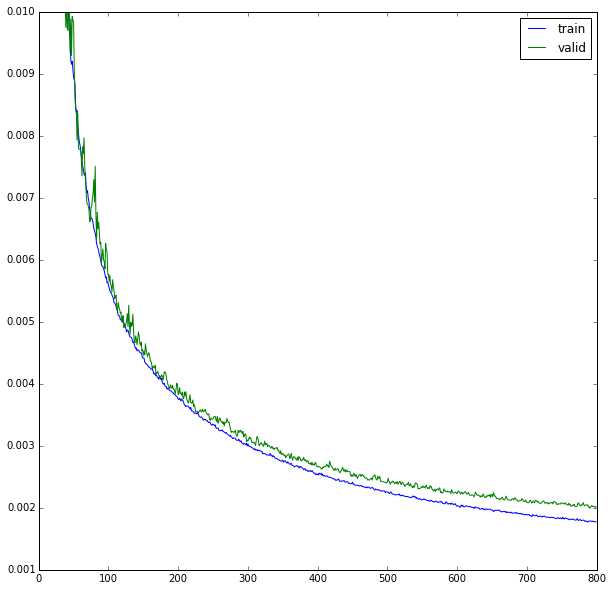

In [97]:
net3_train_errors = np.array([t["train_loss"] for t in net3.train_history_])
net3_valid_errors = np.array([t["valid_loss"] for t in net3.train_history_])
epochs = np.arange(0, net3_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net3_train_errors, "b-", label = "train")
plt.plot(epochs, net3_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

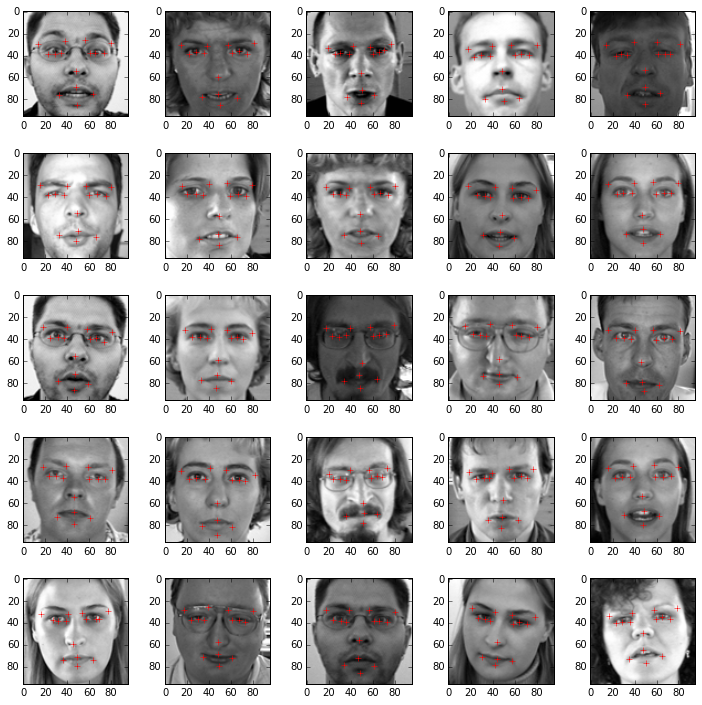

In [98]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net3.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

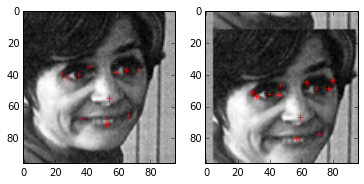

In [14]:
## jitter effect
## example of mirror the image

def jitter(v ,ox, oy):
    vv = v.copy()
    vv[::2] += ox
    vv[1::2] += oy
    return vv

j = 15
ox, oy = np.random.randint(-j, j+1, 2)
i = 0
img = XX[i].reshape((96, 96))
mimg = np.roll(np.roll(XX[i, :, :, :], ox, -1), oy, -2)
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = jitter(y[i,:], ox/48., oy/48. )
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

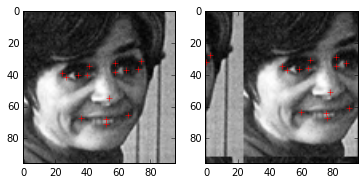

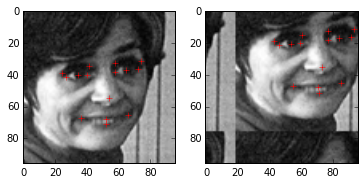

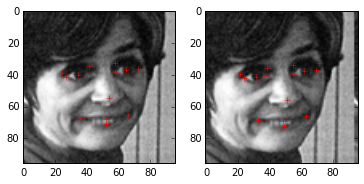

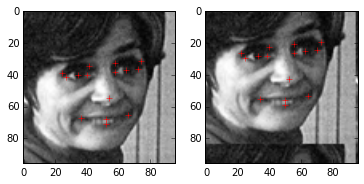

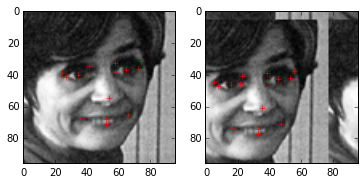

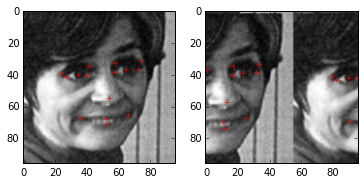

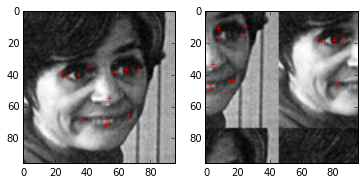

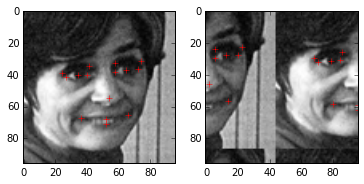

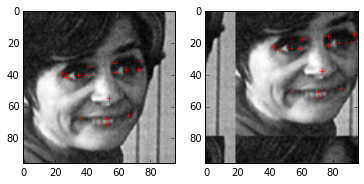

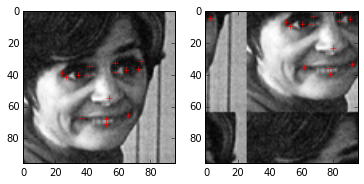

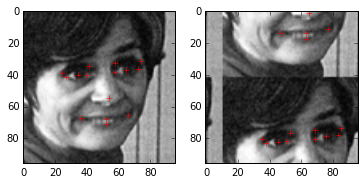

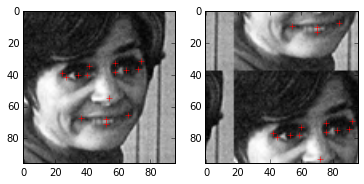

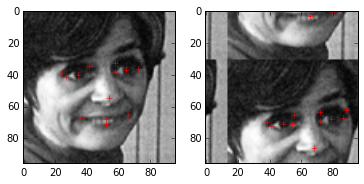

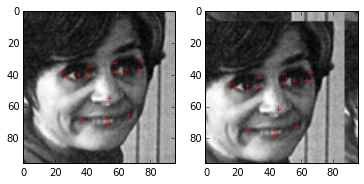

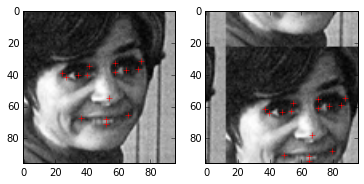

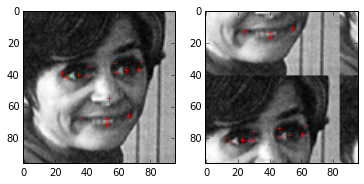

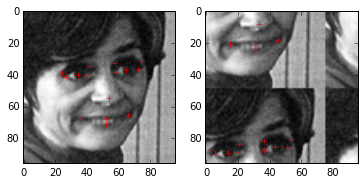

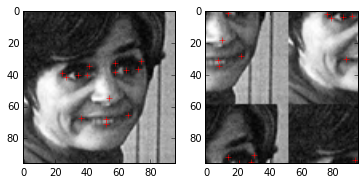

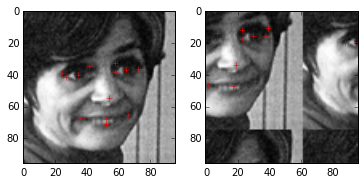

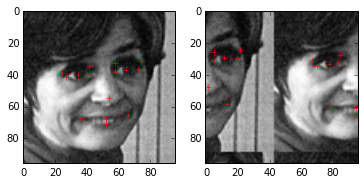

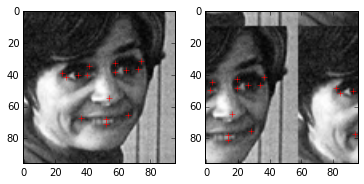

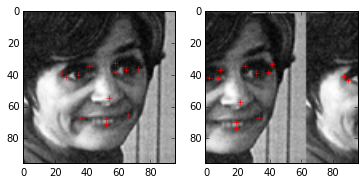

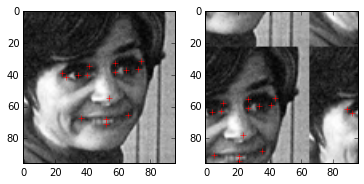

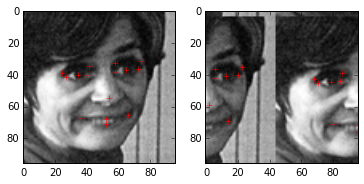

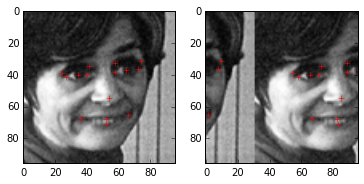

In [29]:
## jitter effect
## example of mirror the image

def jitter(v ,ox, oy):
    vv = v.copy()
    vv[::2] += ox
    vv[1::2] += oy
    vv[vv>1]=vv[vv>1]-2
    vv[vv<-1]=vv[vv<-1]+2
    return vv

j = 25
i = 0
img = XX[i].reshape((96, 96))
mimg = img
my = y[i, :]
for _ in xrange(25):
    ox, oy = np.random.randint(-j, j+1, 2)
    
    mimg = np.roll(np.roll(mimg, ox, -1), oy, -2)
    pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
    mv = jitter(my, ox/48., oy/48. )
    my = mv
    mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

    fig, axes = plt.subplots(1, 2, figsize = (6, 3))
    plot_face(img, ax=axes[0])
    plot_features(pts, ax = axes[0])

    plot_face(mimg, ax = axes[1])
    plot_features(mpts, ax = axes[1])

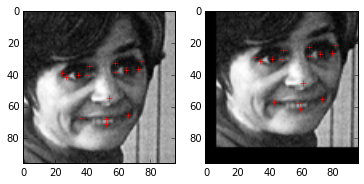

In [16]:
## jitter effect by padding instead of rolling
## example of mirror the image

def jitter(v ,ox, oy):
    vv = v.copy()
    vv[::2] += ox
    vv[1::2] += oy
    return vv



j = 15
ox, oy = np.random.randint(-j, j+1, 2)
i = 0
img = XX[i].reshape((96, 96))
mimg = np.roll(np.roll(XX[i, :, :, :], ox, -1), oy, -2)
if ox > 0: 
    mimg[:,:, :ox] = 0
else:
    mimg[:,:,ox:] = 0
if oy > 0: 
    mimg[:, :oy,:] = 0
else:
    mimg[:,oy:, :] = 0
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = jitter(y[i,:], ox/48., oy/48. )
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

In [17]:
## use BatchIterator to do on-the-fly image augumentation
# boht filpping and jittering

## Jittering causes diverge!!!! VERY bad performance even we think jittering and octaving would help
## generalize better in general - didnt manage to make the network converge

from nolearn.lasagne.base import BatchIterator


class FlipAndOffsetBatchIterator(BatchIterator):
    def transform(self, Xbb, ybb):
        """
        Xb, yb are batch of inputs and outputs
        Flip 1/3 of images leftside right, Flip 1/3 of images upside down
        """
        Xb, yb = Xbb.copy(), ybb.copy() # deep copy to avoid accumulative effect o jittering
        Xb, yb = super(FlipAndOffsetBatchIterator, self).transform(Xb, yb)
        batch_size = Xb.shape[0]
        ## vertical flip
        selected = np.random.choice(batch_size, batch_size/2, replace = False)
        N = selected.shape[0]
        Xb[selected[:N/2], ...] = Xb[selected[:N/2], :, :, ::-1]
        yb[selected[:N/2], ...] = np.array(map(mirror_vertical, yb[selected[:N/2], ...]))
        ## jitter offset
        j = 5
        ox, oy = np.random.randint(-j, j+1, 2)
        Xb[selected[N/2:N*6/10], ...] = np.roll(np.roll(Xb[selected[N/2:N*6/10], :, :, :], ox, -1), oy, -2, )
        yb[selected[N/2:N*6/10], ...] = np.array(map(lambda v: jitter(v, ox/48., oy/48. ), yb[selected[N/2:N*6/10], ...]))
        return Xb, yb
    
net5 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (2, 2) # 32 x 95 x 95
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = 0.01 ## deafults are good start
    , update_momentum = 0.9
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 800
    , verbose = 1
    
    ## data arugment batch iterator - by fliping images vertically and horizontally
    , batch_iterator_train=FlipAndOffsetBatchIterator(batch_size = 64)
)
#net3 = cPickle.load(open("../data/kaggle-facial-keypoints/models/lasagne/net3.pkl"))
#net5.load_params_from(net3.get_all_params_values())

%time net5.fit(XX, y)

# Neural Network with 8051342 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x95x95
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.05971       0.00910      6.56128  5.40s
      2       0.00875       0.00718      1.21822  5.39s
      3       0.00737       0.00651      1.13175  5.44s
      4       0.00661       0.00613      1.07810  5.41s
      5       0.00634       0.00584      1.08499  5.39s
      6       0.00624       0.00560      1.11506  5.41s
      7       0.00594       0.00536      1.10841  5.39s
      8       0.00564       0.00521      1.08431  5.38s
      9       0.00561       0.00506      1.10892  5.37s
     10       0.00549       0.00492      1.11569  5.3

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fd6aead3750>,
     batch_iterator_train=<__main__.FlipAndOffsetBatchIterator object at 0x7fd6545c2f10>,
     conv1_filter_size=(2, 2), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=800, more_params={},
     objective=<function objective at 0x7fd6aead99b0>,
     objectiv

(0.001, 0.01)

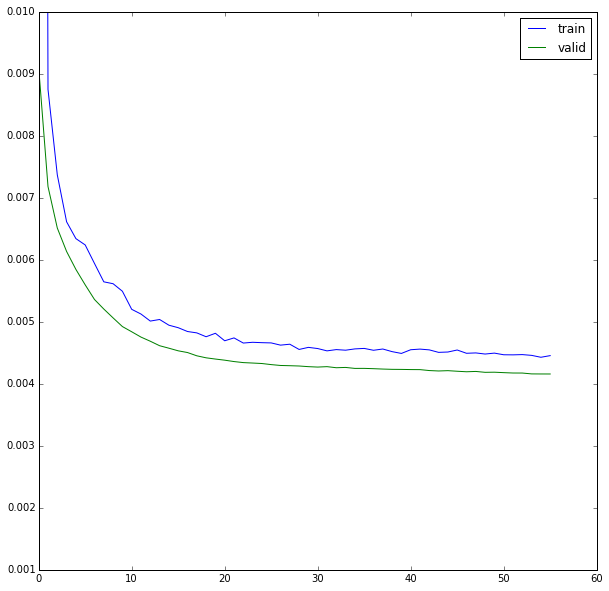

In [18]:
net5_train_errors = np.array([t["train_loss"] for t in net5.train_history_])
net5_valid_errors = np.array([t["valid_loss"] for t in net5.train_history_])
epochs = np.arange(0, net5_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net5_train_errors, "b-", label = "train")
plt.plot(epochs, net5_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

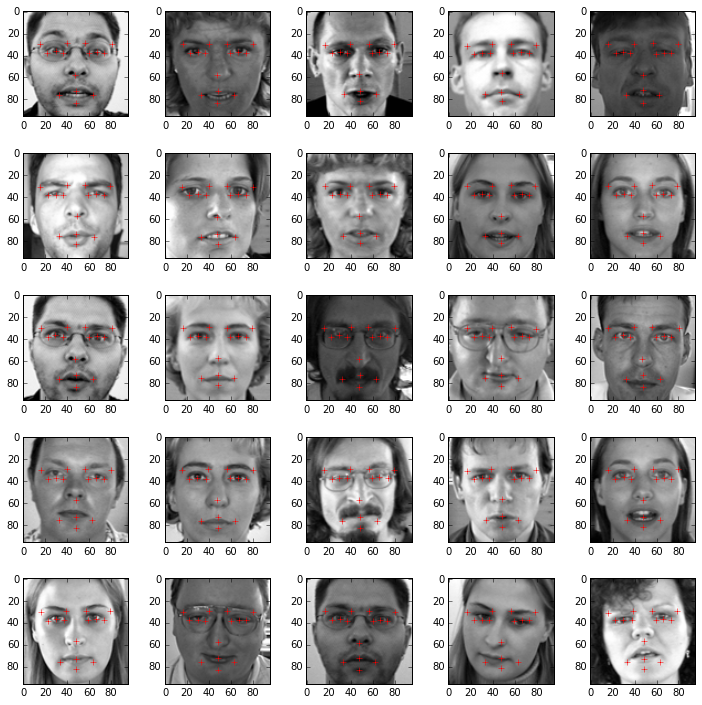

In [19]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net5.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

### make convergence faster by making learning_rate and momentum dynamic
- make the learning rate decrease linearly with epochs
- make the momentum increase linearly with epochs
- do it by hooking on_epoch_finished call back
- use theano.shared variable because almost all parameters in theano and lasagne are theano.shared variables

In [21]:
class AdjustableVriable(object):
    def __init__(self, name, start, end):
        self.name = name
        self.start = start
        self.end = end
        self.valuerange = None
    def __call__(self, nn, train_history):
        if self.valuerange == None:
            self.valuerange = np.linspace(self.start, self.end, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = np.cast[np.float32](self.valuerange[epoch-1])
        ## set shared variable values
        getattr(nn, self.name).set_value(new_value)

In [55]:
from nolearn.lasagne.base import BatchIterator


class FlipAndOffsetBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        """
        Xb, yb are batch of inputs and outputs
        Flip 1/3 of images leftside right, Flip 1/3 of images upside down
        """
        Xb, yb = super(FlipAndOffsetBatchIterator, self).transform(Xb, yb)
        batch_size = Xb.shape[0]
        ## vertical flip
        selected = np.random.choice(batch_size, batch_size/2, replace = False)
        N = selected.shape[0]
        Xb[selected[:N/2], ...] = Xb[selected[:N/2], :, :, ::-1]
        yb[selected[:N/2], ...] = np.array(map(mirror_vertical, yb[selected[:N/2], ...]))
        ## jitter offset
        j = 0
        ox, oy = np.random.randint(-j, j+1, 2)
        Xb[selected[N/2:N*6/10], ...] = np.roll(np.roll(Xb[selected[N/2:N*6/10], :, :, :], ox, -1), oy, -2, )
        if ox > 0: 
            Xb[selected[N/2:N*6/10], :,:, :ox] = 0
        elif ox < 0:
            Xb[selected[N/2:N*6/10], :,:,ox:] = 0
        if oy > 0: 
            Xb[selected[N/2:N*6/10], :, :oy,:] = 0
        elif oy < 0:
            Xb[selected[N/2:N*6/10], :,oy:, :] = 0
        yb[selected[N/2:N*6/10], ...] = np.array(map(lambda v: jitter(v, ox/48., oy/48. ), yb[selected[N/2:N*6/10], ...]))
        return Xb, yb
    
net6 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (3, 3) # 32 x 94x94
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = theano.shared(np.cast[np.float32](0.03)) ## deafults are good start
    , update_momentum = theano.shared(np.cast[np.float32](0.9))
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 300
    , verbose = 1
    
    ## data arugment batch iterator - by fliping images vertically and horizontally
    , batch_iterator_train=FlipAndOffsetBatchIterator(batch_size = 128)
    , on_epoch_finished = [AdjustableVriable("update_learning_rate", start = 0.03, end = 0.0001), 
                          AdjustableVriable("update_momentum", start = 0.9, end = 0.999)]
)
#net3 = cPickle.load(open("../data/kaggle-facial-keypoints/models/lasagne/net3.pkl"))
#net5.load_params_from(net3.get_all_params_values())

%time net6.fit(XX, y)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.06353       0.01054      6.02602  5.08s
      2       0.00829       0.00684      1.21254  5.09s
      3       0.00628       0.00592      1.06079  5.06s
      4       0.00566       0.00547      1.03377  5.06s
      5       0.00531       0.00516      1.02815  5.06s
      6       0.00508       0.00497      1.02300  5.35s
      7       0.00492       0.00482      1.02070  5.15s
      8       0.00480       0.00471      1.01815  5.23s
      9       0.00471       0.00461      1.01999  5.27s
     10       0.00464       0.00458      1.01209  5.0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f18870fe7d0>,
     batch_iterator_train=<__main__.FlipAndOffsetBatchIterator object at 0x7f183722b810>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=300, more_params={},
     objective=<function objective at 0x7f18861e8050>,
     objectiv

In [32]:
from nolearn.lasagne.base import BatchIterator

## using new jitter function to reduce the effect
## no need to copy the Xb, and yb
def jitter(v ,ox, oy):
    vv = v
    vv[::2] = (vv[::2] + ox) 
    vv[1::2] = (vv[1::2] + oy)
#     vv[vv>1.] = vv[vv>1.]-2
#     vv[vv<1.] = vv[vv<1.]+2
    return vv

class FlipAndOffsetBatchIterator(BatchIterator):
    def transform(self, Xbb, ybb):
        """
        Xb, yb are batch of inputs and outputs
        Flip 1/3 of images leftside right, Flip 1/3 of images upside down
        """
        Xb, yb = Xbb.copy(), ybb.copy()
        Xb, yb = super(FlipAndOffsetBatchIterator, self).transform(Xb, yb)
        batch_size = Xb.shape[0]
        ## vertical flip
        selected = np.random.choice(batch_size, batch_size/2, replace = False)
        N = selected.shape[0]
        ## vertical flip
        Xb[selected[:N/2], ...] = Xb[selected[:N/2], :, :, ::-1]
        yb[selected[:N/2], ...] = np.array(map(mirror_vertical, yb[selected[:N/2], ...]))
        ## jitter offset
        j = 10
        ox, oy = np.random.randint(-j, j+1, 2)
        #ox, oy = 2, 2
        Xb[selected[N/2:N*6/10], ...] = np.roll(np.roll(Xb[selected[N/2:N*6/10], :, :, :], ox, -1), oy, -2, )
        yb[selected[N/2:N*6/10], ...] = np.array(map(lambda v: jitter(v, ox/48., oy/48. ), yb[selected[N/2:N*6/10], ...]))
#         yyb = yb.copy()
#         yyb[selected[N/2:N*6/10], ...] = np.array(map(lambda v: jitter(v, ox/48., oy/48. ), yb[selected[N/2:N*6/10], ...]))
#         print "==================================="
#         plt.figure()
#         fig, ax = plt.subplots(1, 1, figsize = (3, 3))
#         plot_face(Xb[selected[N/2], 0, :,:].copy(), ax)
#         pts = yb[selected[N/2], :] * 48.+48.
#         pts = zip(pts[::2], pts[1::2])
#         plot_features(pts, ax)
        return Xb, yb
    
net6 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (3, 3) # 32 x 94x94
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = theano.shared(np.cast[np.float32](0.03)) ## deafults are good start
    , update_momentum = theano.shared(np.cast[np.float32](0.9))
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 600
    , verbose = 2
    
    ## data arugment batch iterator - by fliping images vertically and horizontally
    , batch_iterator_train=FlipAndOffsetBatchIterator(batch_size = 128)
    , on_epoch_finished = [AdjustableVriable("update_learning_rate", start = 0.03, end = 0.0001), 
                          AdjustableVriable("update_momentum", start = 0.9, end = 0.999)]
)
#net3 = cPickle.load(open("../data/kaggle-facial-keypoints/models/lasagne/net3.pkl"))
#net5.load_params_from(net3.get_all_params_values())

%time net6.fit(XX, y)

# Neural Network with 8051502 learnable parameters

## Layer information

name     size         total    cap.Y    cap.X    cov.Y    cov.X
-------  ---------  -------  -------  -------  -------  -------
input    1x96x96       9216   100.00   100.00   100.00   100.00
conv1    32x94x94    282752   100.00   100.00     3.12     3.12
pool1    32x47x47     70688   100.00   100.00     3.12     3.12
conv2    64x46x46    135424    80.00    80.00     5.21     5.21
pool2    64x23x23     33856    80.00    80.00     5.21     5.21
conv3    128x22x22    61952    88.89    88.89     9.38     9.38
pool3    128x11x11    15488    88.89    88.89     9.38     9.38
hidden4  500            500   100.00   100.00   100.00   100.00
hidden5  500            500   100.00   100.00   100.00   100.00
output   30              30   100.00   100.00   100.00   100.00

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    ima

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fd6aead3750>,
     batch_iterator_train=<__main__.FlipAndOffsetBatchIterator object at 0x7fd626dbbf50>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=600, more_params={},
     objective=<function objective at 0x7fd6aead99b0>,
     objectiv

(0.001, 0.01)

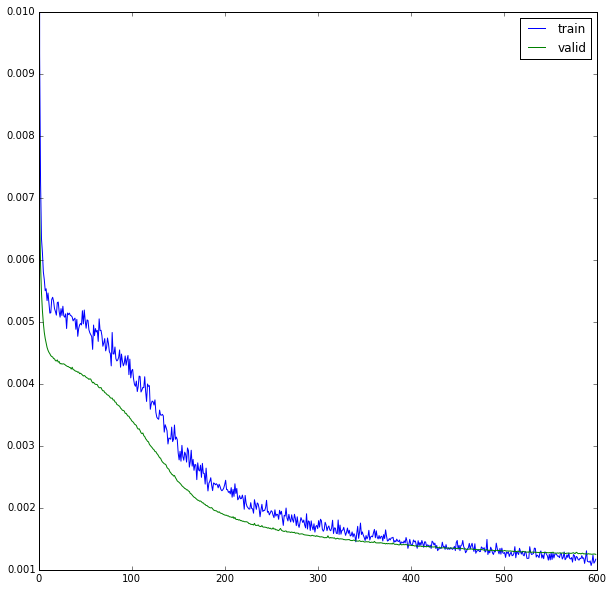

In [33]:
net6_train_errors = np.array([t["train_loss"] for t in net6.train_history_])
net6_valid_errors = np.array([t["valid_loss"] for t in net6.train_history_])
epochs = np.arange(0, net6_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net6_train_errors, "b-", label = "train")
plt.plot(epochs, net6_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

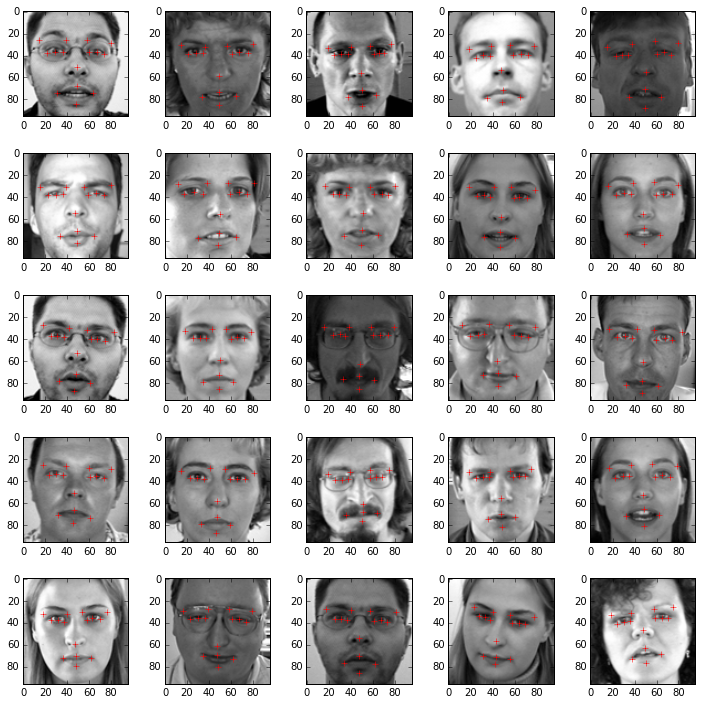

In [34]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net6.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

In [35]:
cPickle.dump(net6, open("../data/kaggle-facial-keypoints/models/lasagne/net6.pkl", "w"), -1)